In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import re
import numpy as np
sys.path.append("../")
from qmg.utils import FitnessCalculatorWrapper, FitnessCalculator

def get_logger_data(logger_path):
    data = {
        "iteration number": [],
        "product_validity_uniqueness": [],
        "ClogP": [],
        "CMR": []
    }

    with open(logger_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # 暫存當前的 iteration number
    current_iteration = None
    product_validity_value = None
    clogp_value = None
    cmr_value = None

    # 用 state machine 的概念處理：當讀到 iteration number 後，預期接下來會出現 product_validity_uniqueness、ClogP、CMR
    for line in lines:
        line = line.strip()
        
        # 匹配 Iteration number 行
        match_iteration = re.search(r'Iteration number:\s*(\d+)', line)
        if match_iteration:
            # 如果之前已經有紀錄一組完整的數據（上一次的 iteration 完成）
            # 就將其加入 data
            if current_iteration is not None and product_validity_value is not None and clogp_value is not None and cmr_value is not None:
                data["iteration number"].append(current_iteration)
                data["product_validity_uniqueness"].append(product_validity_value)
                data["ClogP"].append(clogp_value)
                data["CMR"].append(cmr_value)

            # 重設當前 iteration 的暫存值
            current_iteration = int(match_iteration.group(1))
            product_validity_value = None
            clogp_value = None
            cmr_value = None
            continue

        # 匹配 product_validity_uniqueness 行
        match_product = re.search(r'product_validity_uniqueness \(maximize\):\s*([0-9.]+)', line)
        if match_product:
            product_validity_value = float(match_product.group(1))
            continue

        # 更通用地匹配 ClogP 行
        match_clogp = re.search(r'ClogP.*:\s*([-\d.]+)', line)
        if match_clogp:
            clogp_value = float(match_clogp.group(1))
            continue

        # 匹配 CMR 行
        match_cmr = re.search(r'CMR.*:\s*([-\d.]+)', line)
        if match_cmr:
            cmr_value = float(match_cmr.group(1))
            continue

    # 最後檢查最後一組 iteration (因為結束時可能沒再出現新 iteration number 行)
    if current_iteration is not None and product_validity_value is not None and clogp_value is not None and cmr_value is not None:
        data["iteration number"].append(current_iteration)
        data["product_validity_uniqueness"].append(product_validity_value)
        data["ClogP"].append(clogp_value)
        data["CMR"].append(cmr_value)

    # 將整理好的資料轉成 DataFrame
    df = pd.DataFrame(data)
    return df

prefix = "../results_chemistry_constraint_bo/ClogP_CMR_"
data_path_list = [prefix+"1.log", prefix+"2.log", prefix+"5.log", prefix+"6.log",]
data_list = [get_logger_data(data_path) for data_path in data_path_list]
target_value_list = [(None, -1, 25), (None, -1, 35), (None, 1, 25), (None, 1, 35)] # ClogP and CMR
# Teal, Dark orange, Magenta, Purple
color_list = ['#1b9e77', '#d95f02', '#e7298a', '#7570b3']
#["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
target_list = ["product_validity_uniqueness", "ClogP", "CMR"]
name_list = [f"ClogP = {x}, CMR = {y}" for _, x,y in target_value_list]
target_rename_dict = {"product_validity_uniqueness": "Validity $\\times$ \nuniqueness (-)", "ClogP": "ClogP (-)", "CMR": r"CMR ($\mathrm{cm}^3/\mathrm{mol}$)"}

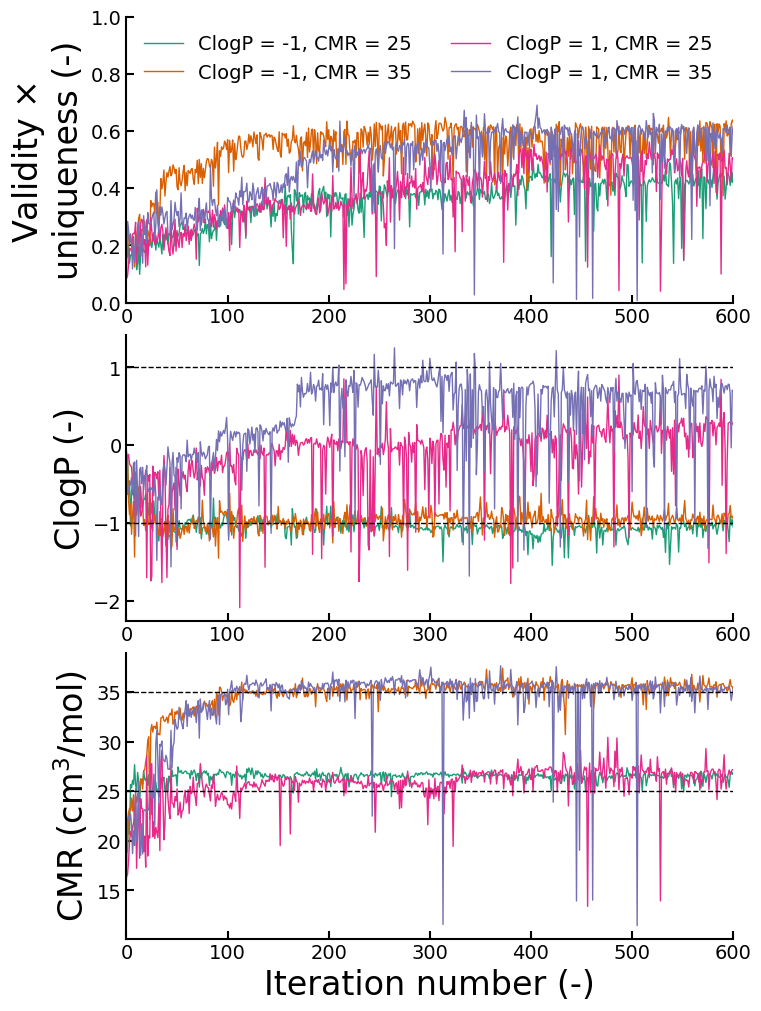

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Nature-style plot settings
plt.rcParams.update({
    'font.size': 12,                # 字體大小
    'axes.labelsize': 14,          # 軸標籤字體大小
    'xtick.labelsize': 14,         # x 軸刻度字體大小
    'ytick.labelsize': 14,         # y 軸刻度字體大小
    'legend.fontsize': 12,         # 圖例字體大小
    'figure.figsize': [7., 12],   # 圖片大小（長度增加以適合垂直合併）
    'lines.linewidth': 2,          # 線條寬度
    'axes.linewidth': 1.5          # 坐標軸寬度
})

# 創建多行圖表佈局
fig, axs = plt.subplots(len(target_list), 1, figsize=(7.5, 10), constrained_layout=True)

total_iteration = 600

for i, (target, ax) in enumerate(zip(target_list, axs)):
    for data, name, color_code in zip(data_list, name_list, color_list):
        new_data = data.iloc[5:].reset_index(drop=True)
        ax.plot(new_data.index, new_data[target], label=name, color=color_code, linewidth=1)

    # 添加虛線作為參考線
    if target == "ClogP":
        ax.axhline(1, color='black', linestyle='--', linewidth=1)  # ClogP 上限
        ax.axhline(-1, color='black', linestyle='--', linewidth=1)  # ClogP 下限
    elif target == "CMR":
        ax.axhline(25, color='black', linestyle='--', linewidth=1)  # CMR 目標值
        ax.axhline(35, color='black', linestyle='--', linewidth=1)  # CMR 上限

    # 坐標軸設定
    ax.set_ylabel(target_rename_dict[target], fontsize=24)
    ax.set_xlim(left=0, right=total_iteration)
    ax.tick_params(axis='both', which='major', direction='in', length=6, width=1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 第一個子圖需要顯示圖例
    if i == 0:
        ax.legend(loc="upper left", frameon=False, ncol=2, fontsize=14)
        ax.set_ylim(0, 1)
else:
    ax.set_xlabel('Iteration number (-)', fontsize=24)

# 儲存合併後的圖為 PDF
plt.savefig('figures/optimization_iteration_plot.svg', dpi=300, format="svg")
plt.show()
